# Neural Network Example

### Authors: Brandon G. Jacques and Per B. Sederberg

## Overview

**GOAL: Learn to predict what letter is coming next given the context of the entire set of letters that came before it.**

In this notebook, we will be covering three timeseries prediction models with identical architectures except for their representation of the past: a Fixed Buffer, an Long Short-Term Memory (LSTM) node, or a Scale-Invariant Temporal History (SITH). The sequence in this case is the speech about the Sith Lord Darth Plagueis the Wise from Star Wars Episode 3. Individual letters will be presented to the model, one at a time as tokenized indices, and the model will have to generate a prediction of what letter should occur next via a log probability. The letter assigned the highest probability is the one that the model will choose to occur next.  

This notebook is broken up into a few sections. The first is a data pre-processing section where we clean the entire speach and break tokenize it for input to the model. Then we set up common training and testing code for all the models. Finally, we define a pytorch implementations of all three models, then train each identically, showing graphs of the loss and accuracy as a function of training epoch.  


In [1]:
%matplotlib inline

In [4]:
# Imports, nothing exciting here!
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn
import torch.nn.functional as F
import sys

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)

# code to ease execution for the poor non-cuda devices of the world
if device == 'cuda':
    torchtypes=torch.cuda
    usecuda=True
else:
    torchtypes=torch
    usecuda=False

def safecuda(oo, *args, **kwargs):
    if usecuda:
        return oo.cuda(*args, **kwargs)
    else:
        return oo
    
from sith import SITH

# You might need to install seaborn if you haven't already
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

Using: cpu


## Initialize "Corpus"

Set up the corpus, tokenize the input, and create a list of the target letters

In [2]:
# Define what goes at the end of a sentence, and what comes in the middle of 
# sentences
sentence_enders = ["?", ".", "!"]
separators = ["\'", ","]

# These are all of the tokens included in the stimuli that our model will be 
# seeing
letters = list("abcdefghijklmnopqrstuvwxyz".upper()) + ["<,>", ".", " "]

# create letter ids for the tokenizer function later
let_to_id = {s:x for x,s in enumerate(letters)}
# create a lookup table for model verification later
id_to_let = dict([[v,k] for k,v in let_to_id.items()])

# Read in the entire text
full_text = open("plagueis.txt", "r").read()

# Make them all captical letters, and remove ellipsis. Add space before each 
# sentence ender and sentence separator
full_text = full_text.upper()
full_text = full_text.replace("...", ".")
full_text = full_text.replace(".", " .")
full_text = full_text.replace("?", " ?")
full_text = full_text.replace(",", " ,")
full_test = full_text.replace("\'", " \'")

# split into individual words
split_text = full_text.split()

master_list = []
id_list = []

# Generate list of letter id's to be turned into 1-hot vectors by a 
# tokenizing function. The letter A has the id 0. The letter Z is 25. etc. 
for s in split_text:
    # loop over each letter in each word
    for l in s:
        if l in sentence_enders:
            master_list.append(".")
            id_list.append(let_to_id["."])
        elif l in separators:
            master_list.append("<,>")
            id_list.append(let_to_id["<,>"])
        else:
            master_list.append(l)
            id_list.append(let_to_id[l])
    # add a space after each word and after each sentence modifier
    master_list.append(" ")
    id_list.append(let_to_id[" "])

# tokenizing funciton, turns each letter into 
def tokenize(inp_list, num_tokens=10):
    output = torch.zeros(len(inp_list), num_tokens, 1).type(torch.DoubleTensor)
    for i, inp in enumerate(inp_list):
        output[i, inp, 0] = 1.0
    return output


tokens = torch.DoubleTensor(id_list).view(-1, 1)
print(master_list)

['D', 'I', 'D', ' ', 'Y', 'O', 'U', ' ', 'E', 'V', 'E', 'R', ' ', 'H', 'E', 'A', 'R', ' ', 'T', 'H', 'E', ' ', 'T', 'R', 'A', 'G', 'E', 'D', 'Y', ' ', 'O', 'F', ' ', 'D', 'A', 'R', 'T', 'H', ' ', 'P', 'L', 'A', 'G', 'U', 'E', 'I', 'S', ' ', 'T', 'H', 'E', ' ', 'W', 'I', 'S', 'E', ' ', '.', ' ', 'I', ' ', 'T', 'H', 'O', 'U', 'G', 'H', 'T', ' ', 'N', 'O', 'T', ' ', '.', ' ', 'I', 'T', '<,>', 'S', ' ', 'N', 'O', 'T', ' ', 'A', ' ', 'S', 'T', 'O', 'R', 'Y', ' ', 'T', 'H', 'E', ' ', 'J', 'E', 'D', 'I', ' ', 'W', 'O', 'U', 'L', 'D', ' ', 'T', 'E', 'L', 'L', ' ', 'Y', 'O', 'U', ' ', '.', ' ', 'I', 'T', '<,>', 'S', ' ', 'A', ' ', 'S', 'I', 'T', 'H', ' ', 'L', 'E', 'G', 'E', 'N', 'D', ' ', '.', ' ', 'D', 'A', 'R', 'T', 'H', ' ', 'P', 'L', 'A', 'G', 'U', 'E', 'I', 'S', ' ', 'W', 'A', 'S', ' ', 'A', ' ', 'D', 'A', 'R', 'K', ' ', 'L', 'O', 'R', 'D', ' ', 'O', 'F', ' ', 'T', 'H', 'E', ' ', 'S', 'I', 'T', 'H', ' ', '<,>', ' ', 'S', 'O', ' ', 'P', 'O', 'W', 'E', 'R', 'F', 'U', 'L', ' ', 'A', 'N', 'D'

## Training and testing functions Function
The goal of the each of the models presented in this notebook are to predict the next letter in the "Darth Plagius" speech from Star Wars Episode 2 given the sequence of letters that came before it. The three models will have a very similar structure:

    Input -> Embedding -> Temporal Representation -> Hidden -> Output

We constructed a single function that could train any of the 3 models we are going to examine in this notebook. Each of the models will take in the entire sequence of the "Darth Plagius" speech and calculate the loss based on the predictions that they generate. Each time a model sees the sequence, it will also be subject to a test where we evaluate how many correct answers the model generates. This train_model function will return a dictionary of lists that contains all of the information required to compare the 3 models. 

In [23]:
def train_model(model, tokens,
                optimizer,
                loss_func,
                epochs=1500):
    loss_track = {"val":[],
                  "epoch":[],
                  "acc":[],
                  "name":[]}
    
    
    # The inputs to the models are the character id's from let_to_id
    # and the targets are just the inps offset by 1. 
    inps = tokens[:-1].type(torchtypes.LongTensor)
    targets = tokens[1:, 0].type(torchtypes.LongTensor)
    
    progress_bar = tqdm(range(int(epochs)))
    
    for e in progress_bar:
        # Zero the gradient between each batch
        model.zero_grad()
        
        # Present an entire batch to the model
        out = model(inps)
        
        # Measure loss via CrossEntropyLoss
        loss = loss_func(out, targets)
        
        # Adjust Weights
        if e == 0:
            loss.backward(create_graph=True, retain_graph=True)
        else:
            loss.backward()
        optimizer.step()
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['name'].append(model.__class__.__name__)
        
        acc = test_model(model, tokens)
        loss_track['acc'].append(acc)
        
        # Update progress_bar
        progress_bar.set_description("%i: Loss: %0.6f, Acc: %0.4f" % (e, loss_track['val'][-1], acc))
        
    return loss_track

def test_model(model, tokens):
    # Test for accuracy
    
    inps = tokens[:-1].type(torchtypes.LongTensor)
    targets = tokens[1:,0].type(torchtypes.LongTensor)
    
    out = model(inps)

    # Accuracy: If the maximum value in the output is at the same
    # position as the target id for that input token, then we count it as
    # a correct response
    correct = (out.argmax(-1) == targets).sum().detach().cpu().numpy()
    acc = correct/targets.shape[0]
    return acc

## Define the Models

### Buffer
A very simple model that tracks the embedding features of each letter for some number of buffer positions into the past. Then passes a flattened, but still correctly ordered, vector of all the features within the buffer through a fully connected linear layer before continuing with the rest of the model. 

In [25]:
class BufferLetterModel(torch.nn.Module):
    def __init__(self, buffer_size, num_tokens, 
                 embedding_feat, hidden_size,
                 ):
        super(BufferLetterModel, self).__init__()
        
        self._buff_cuda = usecuda
        
        self.letter_embeddings = torch.nn.Embedding(num_tokens, embedding_feat)
        self._buffer = torch.zeros((buffer_size, embedding_feat), 
                                   requires_grad=False).type(torch.DoubleTensor)
        
        self._buffer = self._buffer.type(torchtypes.DoubleTensor)
            
        self.linear1 = torch.nn.Linear(embedding_feat*buffer_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, num_tokens)
        
    def forward(self, inputs):
        self._buffer = safecuda(torch.zeros_like(self._buffer),device=self._buffer.device)
        batch_size = inputs.shape[0]
        
        output_tensor = torch.zeros(batch_size, 
                                    self._buffer.shape[0],
                                    self._buffer.shape[1]).type(torch.DoubleTensor)
        if self._buff_cuda:
            output_tensor = safecuda(output_tensor, device=self._buffer.device)
        embeds = self.letter_embeddings(inputs)
        c = 0
        for x in embeds.split(1, dim=0):
            self._buffer[1:] = self._buffer[:-1].clone()
            self._buffer[0] = x.squeeze(0)
            output_tensor[c, :, :] = self._buffer.clone()
            c += 1
        
        output_tensor = self.linear1(output_tensor.view(batch_size, -1))
        output_tensor = self.linear2(output_tensor)
        return output_tensor

###  SITH
The SITH representation, as detailed elsewhere, is able to track any number of features in an efficently lossy way. That means that this model will take the letter embeddings and track them as $n$ different features within SITH. We then only take a subset of the $\tau^*$s for each feature and pass them through a linear layer before the rest of the model. 

In [26]:
class SITHLetterModel(torch.nn.Module):
    """input shape: (sequence, 1)"""
    def __init__(self, sith_params, num_tokens, hidden_size):
        """
        Parameters
        ----------
        
            sith_params: dictionary
                A dictionary contianing all the parameters needed to setup the SITH layer.
            """
        super(SITHLetterModel, self).__init__()
        
        self.word_embeddings = torch.nn.Embedding(num_tokens, sith_params['in_features'])
        
        self.sith = SITH(**sith_params)
        if usecuda:
            self.sith.cuda()
        
        num_taustars = self.sith.tau_star.shape[0]
        
        self.linear1 = torch.nn.Linear(sith_params['in_features']*num_taustars, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, num_tokens)
    
    def forward(self, inputs):
        self.sith.reset()
        
        batch_size = inputs.shape[0]
        
        embeds = self.word_embeddings(inputs)
        x = self.sith(embeds.squeeze(1)).view(batch_size, -1)
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

### LSTM

Here we simply drop in an LSTM module for the temporal representation. Given that it basically has a hidden layer built into it, we do not add in the extra linear layer like we did for the buffer and SITH models, however, you'll see below that it still ends up with twice as many weights to learn.

In [27]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        return tag_space

## Instantiate the Models

In [28]:
# make sure all models use the same general parameters
rep_size = 8
hidden_size = 50
embed_size = 15

In [29]:
buff_model = safecuda(BufferLetterModel(buffer_size=rep_size, 
                              num_tokens=len(list(let_to_id.keys())),
                              embedding_feat=embed_size,
                              hidden_size=hidden_size).double())
print(buff_model)

BufferLetterModel(
  (letter_embeddings): Embedding(29, 15)
  (linear1): Linear(in_features=120, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
)


In [30]:
sith_params ={"in_features":embed_size,
              "tau_min":1, "tau_max":40, "k":10,
              "ntau":150, "g":0.0,
              # we want 8 taustars, so we divide the ntau by the
              # rep_size to get our desired T_every
              "T_every":int(150/rep_size)+1, "alpha":1.0, 'ttype':torchtypes.DoubleTensor}
# This is only for making sure you pick the right parameters
sith_model = safecuda(SITHLetterModel(sith_params=sith_params, 
                             num_tokens=len(list(let_to_id.keys())), 
                             hidden_size=hidden_size)).double()
taustars = sith_model.sith.tau_star
print(taustars)
print(sith_model)

tensor([ 1.0000,  1.6006,  2.5620,  4.1008,  6.5638, 10.5062, 16.8166, 26.9170],
       dtype=torch.float64)
SITHLetterModel(
  (word_embeddings): Embedding(29, 15)
  (sith): SITH(
    out_shape=(1, sequence_len, 8, 15)
    (lap): Laplace(15, 1-40 with 150 ntau, k=10, c=0.0251)
  )
  (linear1): Linear(in_features=120, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
)


In [31]:
lstm_model = safecuda(LSTMTagger(embedding_dim=embed_size, 
                        hidden_dim=hidden_size, 
                        vocab_size=len(list(let_to_id.keys())))).double()
print(lstm_model)

LSTMTagger(
  (word_embeddings): Embedding(29, 15)
  (lstm): LSTM(15, 50)
  (hidden2tag): Linear(in_features=50, out_features=29, bias=True)
)


# Train and Test each model!

In [32]:
# all models use the same loss function
lf = torch.nn.CrossEntropyLoss()

In [33]:
print("Starting Buff")
optim = torch.optim.Adam(buff_model.parameters())
perf_buff = train_model(buff_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting Buff


In [34]:
print("Starting SITH")
optim = torch.optim.Adam(sith_model.parameters())
perf_sith = train_model(sith_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting SITH


In [35]:
print("Starting LSTM")
optim = torch.optim.Adam(lstm_model.parameters())
perf_lstm = train_model(lstm_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting LSTM


In [36]:
perf1 = pd.DataFrame(perf_buff)
perf2 = pd.DataFrame(perf_sith)
perf3 = pd.DataFrame(perf_lstm)
results = pd.concat([perf1, perf2, perf3])

In [37]:
loss = []
for x in results["val"][:].values:
    loss.append(float(x))
results.val = loss

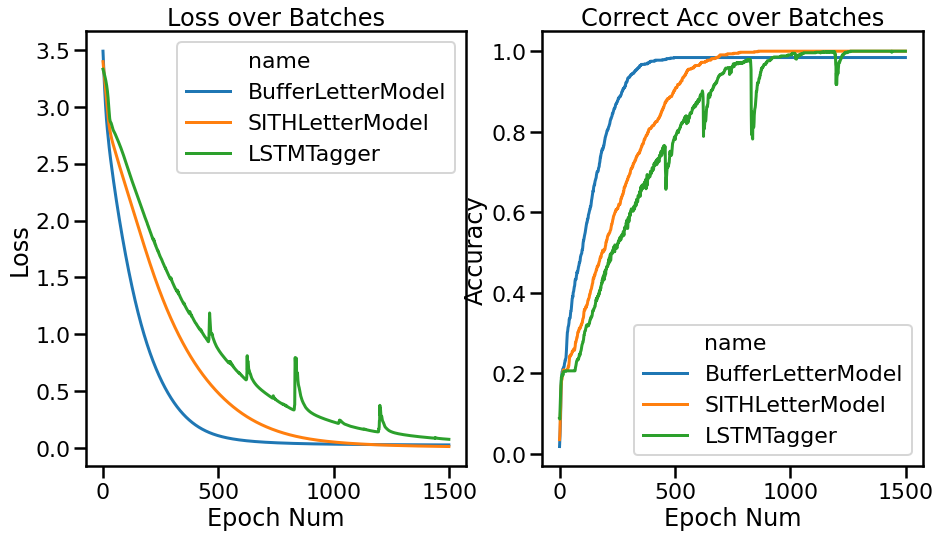

In [38]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1,2,1)
sn.lineplot(data=results, x='epoch', y='val', hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Loss")
ax.set_title("Loss over Batches")
ax = fig.add_subplot(1,2,2)
sn.lineplot(data=results, x='epoch', y='acc', hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Accuracy")
ax.set_title("Correct Acc over Batches")

# Please note that the line that is in the left graph highly fluctuates
# based on the batch within an epoch, so it looks like a filled in area but 
# is actually just a highly fluctuating line. 

# it should also be noted that a buffer of size 10 will never reach 100% 
# accuracy with this model. 
plt.savefig("results_eval", bbox_inches="tight")

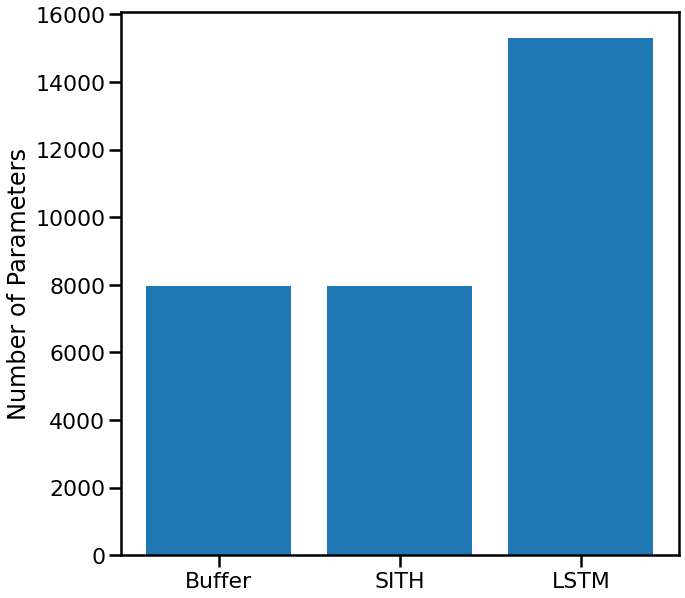

In [39]:
fig = plt.figure(figsize=(10,10))
plt.bar(["Buffer", "SITH", "LSTM"],
        [sum(p.numel() for p in buff_model.parameters()),
         sum(p.numel() for p in sith_model.parameters()),
         sum(p.numel() for p in lstm_model.parameters())])
plt.ylabel("Number of Parameters")
plt.savefig("weights", bbox_inches="tight")

## Buffer Letter Embeddings

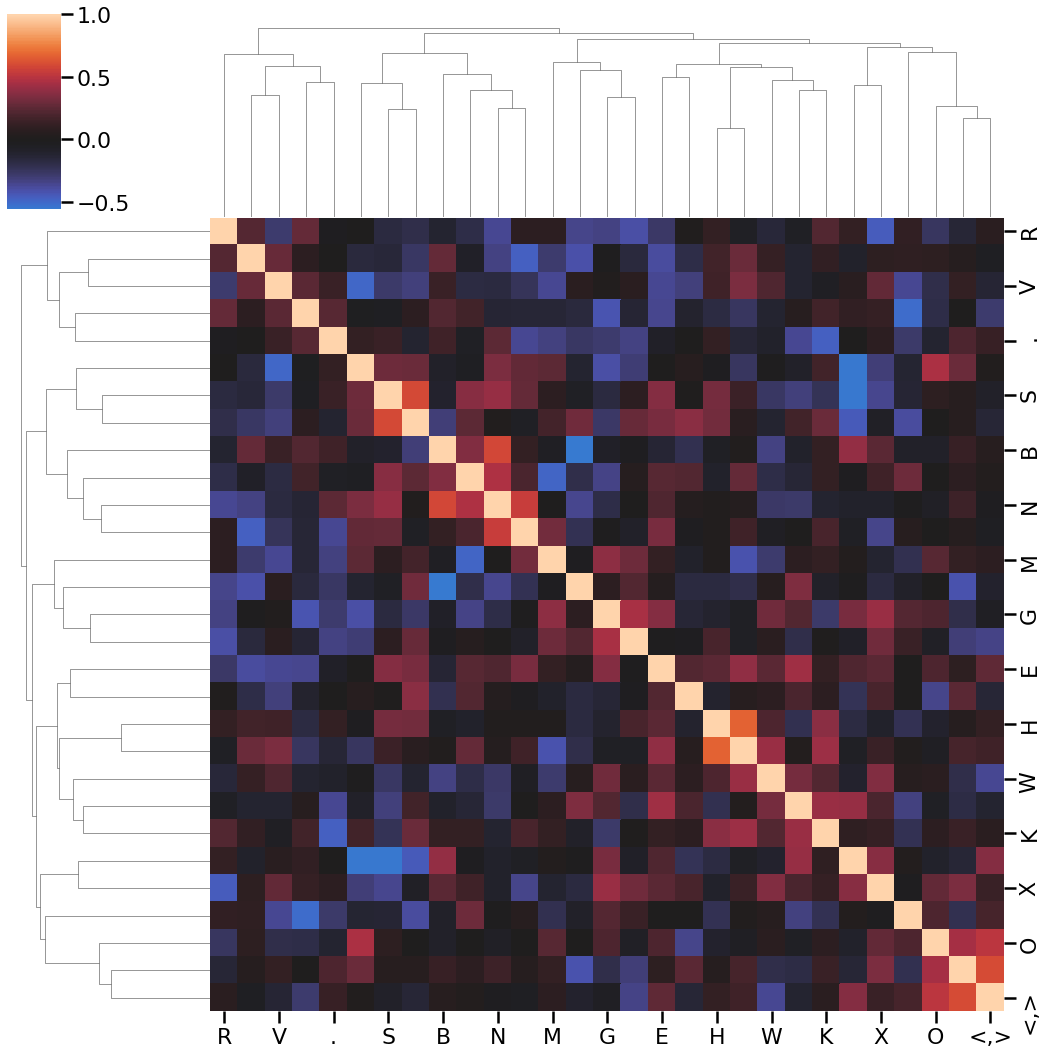

In [40]:
df = pd.DataFrame(buff_model.letter_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(15,15), data=df.corr(), center=0)

## SITH Letter Embeddings

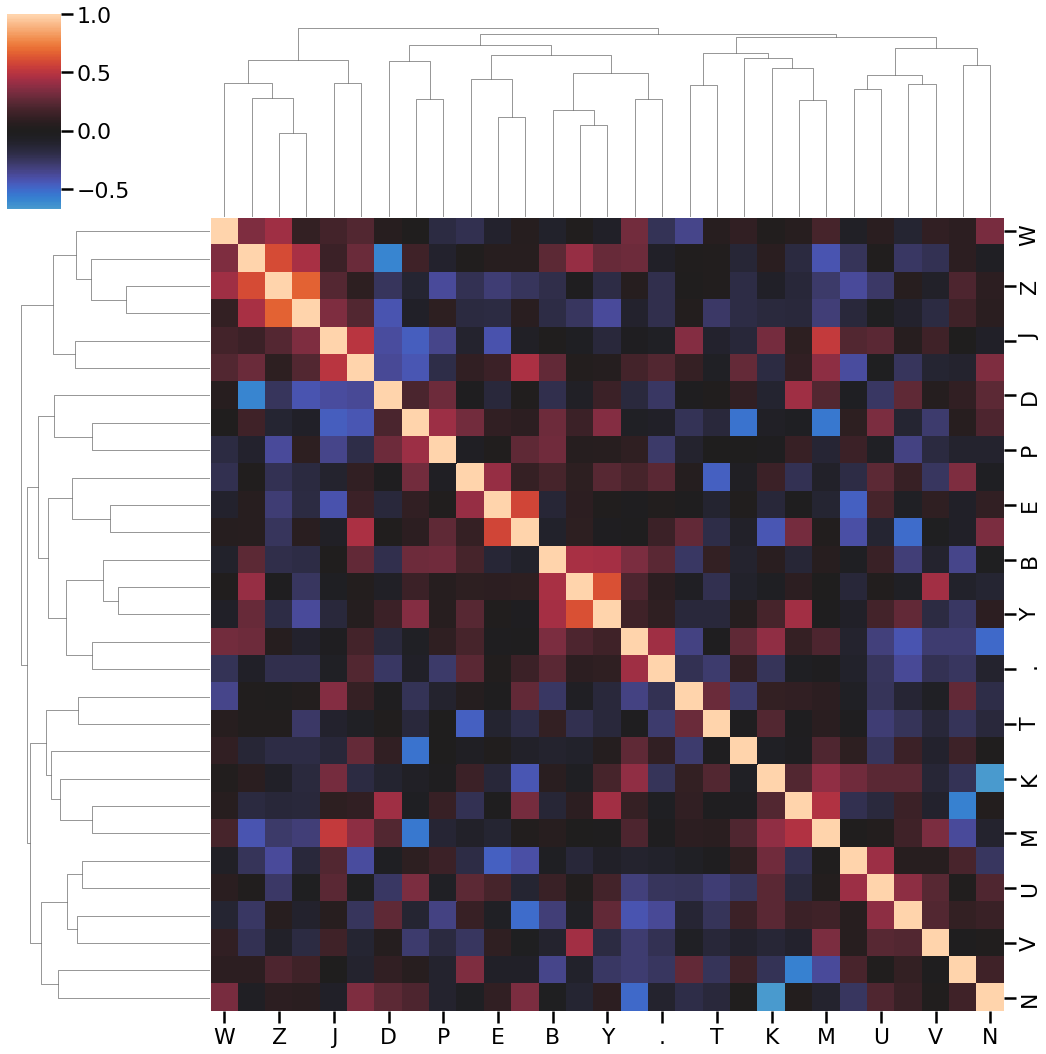

In [41]:
df = pd.DataFrame(sith_model.word_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(15,15), data=df.corr(), center=0)


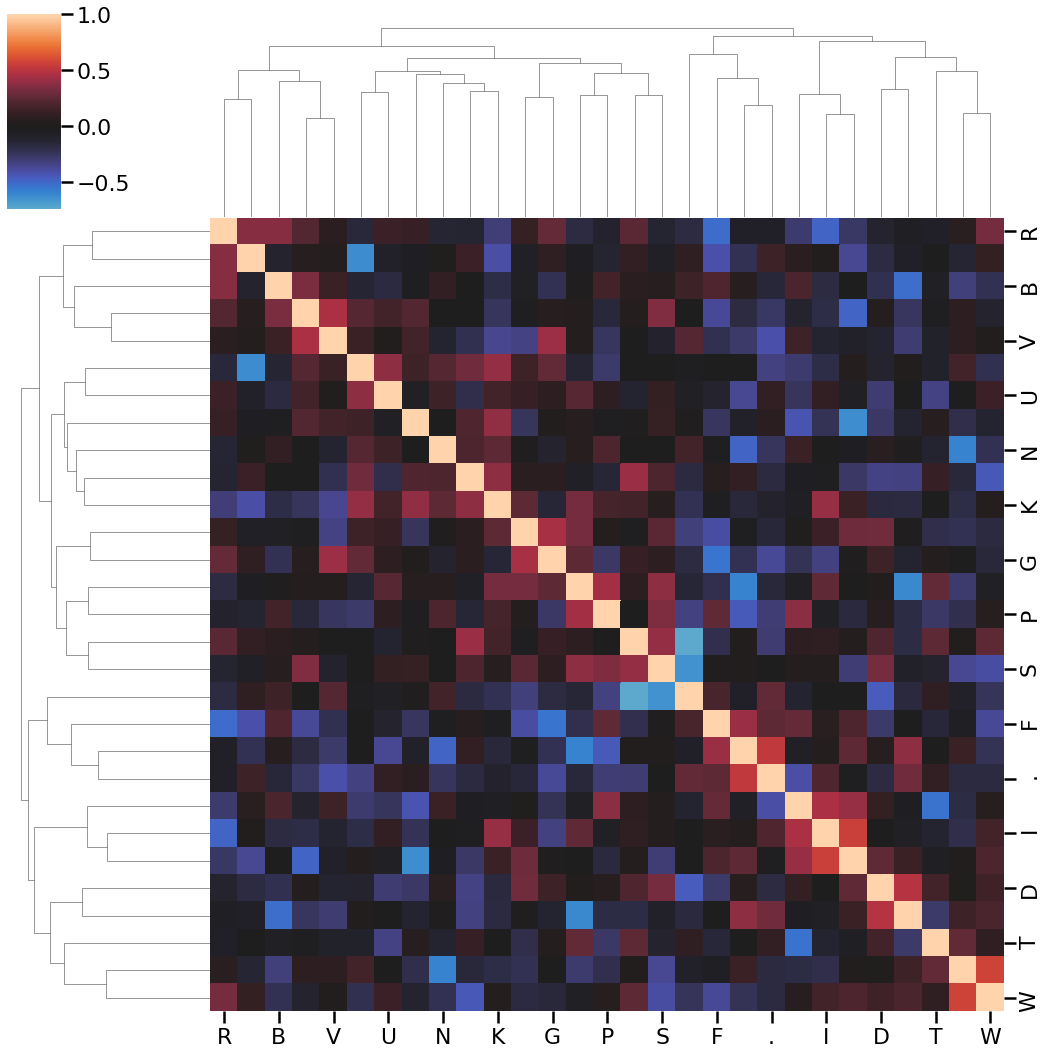

In [39]:
df = pd.DataFrame(sith_model.word_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(15,15), data=df.corr(), center=0)


## LSTM Letter Embeddings

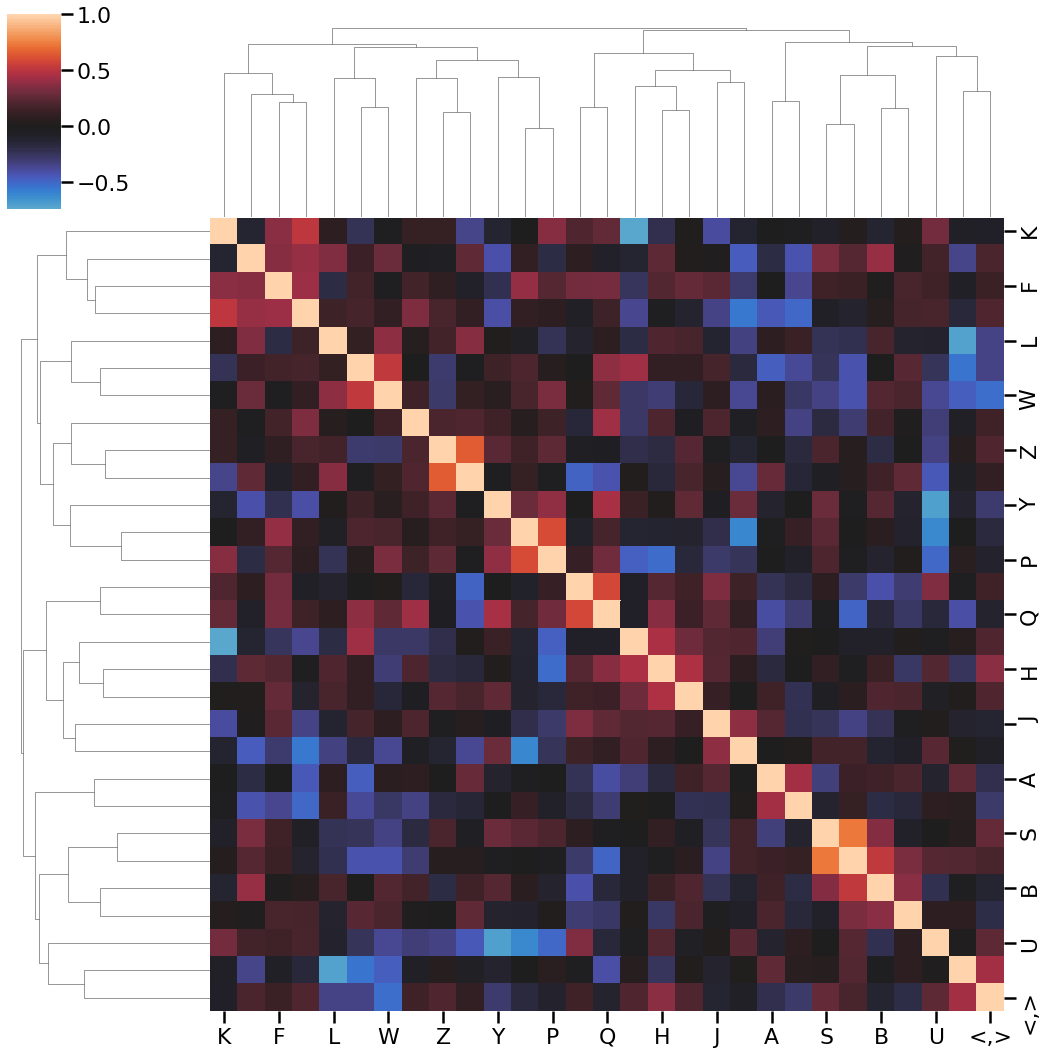

In [42]:
df = pd.DataFrame(lstm_model.word_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(15,15), data=df.corr(), center=0)